# Экскурс в то, что это за данные такие

Вся информация взята из [статьи](https://www.frontiersin.org/articles/10.3389/fmicb.2020.00257/full), указанной на непосредственно на kaggle. 

Бактерии существуют. У них есть ДНК. ДНК состоит из нуклеотидов. В число нуклеотидов входит аденин, тимин, гуанин, цитозин (далее A, T, G и C соот-венно ~~, ибо иначе я задолбаюсь~~)

Есть некоторые бактерии, которые врачи хотели бы уметь классифицировать. Что характерно, классифицировать их таки научились, однако в ряде случаев классификация происходит слишком медленно - зачастую за более, чем 24 часа. С помощью физики и его величества мат.анализа мы можем быстро получать информацию о количестве A, T, G и С, но не о их порядке. Т.е, о сегменте, например, $ATATGGCCTT$ быстро мы можем сказать только то, что в нём по два раза встречаются A, G, C и 4 раза T. Обозначают это как $A_2T_4G_2C_2$, а называют блочным оптическим содержимым (block optical content, BOC). Распределение этих самых BOC для некоторой бактерии зовётся FBC-спектром

Возвращаясь к нашим данным, признаки - столбцы вида $A_wT_xG_yC_z$ c $w, x, y, z \in \mathbb{N} \cup \{0\}, 0 \leq w, x, y, z \leq 10, w + x + y + z = 10$

Авторы статьи поступают следующим образом: 

1. Берут бактерию 
2. Смотрят на 10 последовательно идущих нуклеотидов 
3. Определяют w, x, y и z 
4. Добавляют единицу к соответствующему столбцу 
5. Повторяют шаги 2-4 $r$ раз. 

Позже будет показано, что в нашем случае $r \in \{1.000.000, 100.000, 1.000, 100\} $ 

После этого все строки делят на сумму чисел в них и из каждого столбца вычитают смещение, которое вычисляется так:

$$bias(A_wT_xG_yC_z) = \frac{1}{4^k} \cdot  \frac{k!}{w! x! y! z!}$$

Суть этого действия описывают так:

We discovered that a key to enhancing the differences in the FBC spectra of various DNA sequences is to subtract from each FBC spectrum the spectrum of totally random ATGC, leaving a spectrum of deviations from randomness. The resulting spectrum is called the “deviation spectrum” for a particular sequence.



# Симулированная ошибка

Авторы некоторым образом симулировали ошибку в измерений, однако то, в чём она заключалась я приводить не стану. Дело в том, что с одной стороны я так и не понял, можно ли использовать эти знания для того, чтобы улучшить качество классификации. С другой стороны, хоть это и совернование на kaggle, выиграть его я не стремлюсь. Моя цель - сделать всё так, будто мне принесли эти данные, рассказали как они были собраны, немного погрузили в предметную область и попросили построить классификатор, а в такой ситуации вряд ли будет много известно об ошибках приборов

# Ближе к делу

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as smapi

import scipy.stats
from tqdm.notebook import tqdm

Во избеждание всеми любимой ситуации, при которой мы когда-то как-то получили хорошую модель, но уже не помним когда и как, напишем небольшой класс, призванный записывать всё необходимое для того, чтоб из таких ситуаций элегантно выходить

In [2]:
import sys
import math

class Logger:
    def __init__(self, estimator = 'XGBClassifier', eda_info = 'Нет', 
                 val_info = '10 блоков, без стандартизации, без PCA',
                 grid = None, best_params = None, comp_info = 'Сравнивались средние значения',
                 scores = None, outfile = r'logs\log_1.txt'):
        
        '''
        
        Параметры:
            estimator (str): Название модели
            
            eda_info (str): Информация о предобработке данных. Например, 'предварительно с помощью некоторого
                            алгоритма были удалены выбросы'
            
            val_info (str): Информация о валидации: кол-во блоков, использование стандартизации и т.д
            
            grid (dict): Сетка, по которой перебирались гиперпараметры 
            
            best_params (dict): Набор параметров, показавший себя лучше остальных 
            
            comp_info (str): Информация о том, как в процессе валидации сравнивались модели с разными параметрами
            
            scores (numpy.ndarray, tuple): Набор значений метрики лучшей модели по время валидации или кортеж вида
                                         (среднее значение, стандартное отклонение)
            
            outfile (str): Путь к файлу, в который вся информация будет записана 
        
        Возвращаемое значение:
            Объект класса 
        
        '''
        
        self.estimator = estimator
        self.eda_info = eda_info
        self.val_info = val_info
        self.grid = grid
        self.best_params = best_params
        self.comp_info = comp_info
        self.scores = scores
        self.outfile = outfile
        
        # Частенько сетка состоит из одной точки, т.е просто проводится валидация с помощью функции
        # для поиска по сетке, ибо я ленивая жопа и не написал функцию просто для валидации
        # (что даже справедливо, ибо зачем)
        # В общем, в таком случае будет лишним выводить и сетку, и лучшие параметры
        # Так что заводим индикатор того, что сетка состоит из одной точки
                               # Значения - это списки
        self.only_validation = ( [type(i) for i in self.grid.values()] == [list] * len(self.grid) 
                                 and (math.prod([len(i) for i in self.grid.values()]) == 1) )
        
    def scores_info(self, num_of_tabs = 0):
        '''
        Формирует информацию о метрике лучшей модели. Если информация о метрике представляет из себя
        набор её значений для валидационных блоков, выводится более подробная информация, чем в случае
        когда дано только среднее значение и стандартное отклонение
        
        Параметры:
            num_of_tabs (int): Количество табуляций перед каждой строкой
        
        Возвращаемое значение:
            Строкa с информацией о метрике 
        
        '''
        tabs = '\t' * num_of_tabs
        info = ''
        if type(self.scores) == np.ndarray:
            info += f'{tabs}Точность: {self.scores.mean()} +- {self.scores.std()} (mean +- std)\n'
            info += f'{tabs}Худшая точность: {self.scores.min()}\n'
            info += f'{tabs}Медианная точность: {np.median(self.scores)}\n'
            info += f'{tabs}Лучшая точность: {self.scores.max()}\n'
        else:
            info += f'{tabs}Точность: {self.scores[0]} +- {self.scores[1]} (mean +- std)\n'

        return info
    
    def print_grid(self, stream = sys.stdout):
        '''Выводит информацию о сетке гиперпараметров в указанный поток'''
        stream.write('Сетка:\n')
        for key, value in self.grid.items():
            stream.write(f'\t{key}: {value}\n')
                
    def print_best_params(self, stream = sys.stdout):
        '''Выводит информацию о лучшем наборе гиперпараметров в указанный поток'''
        stream.write('Лучший набор параметров:\n')
        if self.only_validation:
            stream.write('\tСетка состоит из одной точки\n')
            return
        
        for key, value in self.best_params.items():
            stream.write(f'\t{key}: {value}\n')
    
    def make_note(self, print_scores_info = True):
        '''Записывает информацию в файл
        
        Параметры:
            print_scores_info (bool): Если True, вывод информацию о лучшей модели ещё и в sys.stdout
                                      Что (не) происходит в противном случае догадаться не сложно
        
        Возвращаемое значение:
            None
        
        '''
        with open(self.outfile, 'a') as out:
            out.write(f'Модель:\n\t{self.estimator}\n')
            out.write(f'Особенности предобработки данных:\n\t{self.eda_info}\n')
            out.write(f'Особенности валидации:\n\t{self.val_info}\n')
            self.print_grid(stream = out)
            self.print_best_params(stream = out)
            out.write(f'Информация о методе сравнения моделей:\n\t{self.comp_info}\n')
            out.write(f'Информация о метрике:\n{self.scores_info(num_of_tabs = 1)}\n')
            out.write('\n\n' + '*' * 75 + '\n\n')
        
        if print_scores_info:
            print(self.scores_info())

Потратим 10 очков магии на копирование (с небольшим переделыванием) функций из HP

In [3]:
from sklearn.metrics import accuracy_score

In [4]:
def get_na_cols(df):
    out = []
    for col in df.columns:
        if df[col].isna().any():
            out.append(col)
    return out

def print_na(df):
    there_is_nan = False
    for col in df.columns:
        if df[col].isna().sum() != 0:
            print('Column', col, 'has', df[col].isna().sum(), 'NaN values')
            there_is_nan = True
    if not there_is_nan:
        print("There's no NaN values")

In [5]:
def standard(X, features_to_standard, train_index = None, test_index = None):
    '''
    Стандартизирует отдельно подтаблицу с номерами строк из train_index и столбцами из features_to_standard, 
    отдельно с номерами строк из test_index и столбцами из features_to_standard
    
    Параметры:
        X (pandas.DataFrame): Таблица, подлежащая стандартизации

        features_to_standard (list, tuple, pandas.RangeIndex, numpy.ndarray): Список столбцов, содержащих данные, 
                                                                              которые будут стандартизированы

        train_index (list, numpy.ndarray, tuple): Список индексов тренировочного набора 
        
        test_index (list, numpy.ndarray, tuple): Список индексов тестового набора
    
    '''
    EPS = 1e-6
        
    train_mean = X.iloc[train_index][features_to_standard].mean(axis = 0)
    train_std = X.iloc[train_index][features_to_standard].std(axis = 0) + EPS
    X.loc[train_index, features_to_standard] = (X.loc[train_index, features_to_standard] - train_mean) / train_std

    if test_index is not None:
        test_mean = X.iloc[test_index][features_to_standard].mean(axis = 0)
        test_std = X.iloc[test_index][features_to_standard].std(axis = 0) + EPS
        X.loc[test_index, features_to_standard] = (X.loc[test_index, features_to_standard] - test_mean) / test_std
        
        return train_mean, train_std, None, None
    
    return train_mean, train_std, test_mean, test_std

def inverse_standard(X, features_to_standard, train_index = None, test_index = None,
                     train_mean = 0, train_std = 1, test_mean = 0, test_std = 1):
    '''
    Возвращает данные к исходному масштабу
    
    Параметры: 
        X (pandas.DataFrame): Таблица, подлежащая упомянутой трансформации

        features_to_standard (list, tuple, pandas.RangeIndex, numpy.ndarray): Список столбцов, содержащих данные, 
                                                                              которые были стандартизированы

        train_index (list, numpy.ndarray, tuple): Список индексов тренировочного набора 

        test_index (list, numpy.ndarray): Список индексов тестового набора

        train_mean (list, numpy.ndarray): Средние значения признаков из features_to_standard до стандартизации

        train_std (list, numpy.ndarray): Стандартные отклонения признаков из features_to_standard до стандартизации

        test_mean (list, numpy.ndarray): Средние значения признаков из features_to_standard до стандартизации

        test_std (list, numpy.ndarray): Стандартные отклонения признаков из features_to_standard до стандартизации
    
    '''
    X.loc[train_index, features_to_standard] = X.loc[train_index, features_to_standard] * train_std + train_mean
    
    if test_mean is not None and test_std is not None:
        X.loc[test_index, features_to_standard] = X.loc[test_index, features_to_standard] * test_std + test_mean

In [6]:
def teach_and_predict(X_train, y_train, X_test, features_to_standard, model,
                      to_standard = True, **params):
    '''
    Обучает модель model на X_train, делает предсказания на X_test
    
    Параметры: 
        X_train (pandas.DataFrame): Таблица для обучения

        y_train (pandas.Series): Список значений целевой переменной для объектов из X_train

        X_test (pandas.DataFrame): Таблица, для которой нужно предсказать целевую переменную

        features_to_standard (list, tuple, pandas.Index): Список признаков, которые подлежат стандартизации

        model: Что угодно, что имеет методы fit и predict 

        **params (dict): Словарь, в котором ключи - это названия гиперпараметров модели, а значения - значения 
                         гиперпараметров, извиняюсь за тавтологию
                         
    Возвращаемое значение:
        Кортеж из двух элементов. Первый из них - обученная модель, второй - предсказания модели
        для объектов из X_test
    '''

    if to_standard:
        train_mean, train_std, test_mean, test_std = standard(X, features_to_standard, 
                                                              train_index, test_index)
    if with_pca:
        train_before_pca = X.copy()
        train_pca = PCA(n_components = n_comps, whiten = True)
        test_pca = PCA(n_components = n_comps, whiten = True)
        X = pca.fit_transform(X)
        
        X = pd.DataFrame(X, columns = [f'PC{i}' for i in range(1, n_comps + 1)])

        
    model = model(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    
    if with_pca:
        X = X_before_pca.copy()
        
    if to_standard:
        inverse_standard(X, features_to_standard, train_index, test_index,
                         train_mean, train_std, test_mean, test_std)
    
    return model, preds

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

# названия лучше не придумал и в итоге ультанул
def teach_and_predict_while_grid_search(X, y, train_index, test_index, features_to_standard, model = None, 
                                        to_standard = True, with_pca = True, pca_standard = False, 
                                        n_comps = 10, **params):
    '''
    Стандартизует отдельно обучающие блоки и отдельно тестовый блок. После обучает указанную модель 
    с указанными параметрами, считает скор и возвращает данные к исходному масштабу. По сути
    то же, что и teach_and_predict, но принимает данные в удобном во время поиска по сетке формате и 
    при необходимости применяет метод данных компонент
    
    Параметры: 
        X (pandas.DataFrame): Таблица с данными (без целевой переменной)

        y (pandas.Series): Список значений целевой переменной
        
        train_index (list, numpy.ndarray, tuple): Список индексов тренировочного набора 

        test_index (list, numpy.ndarray): Список индексов тестового набора

        features_to_standard (list, tuple, pandas.Index): Список признаков, которые подлежат стандартизации

        model: Что угодно, что имеет методы fit и predict 

        to_standard (bool): Если True, X_test и X_train будут стандартизованы, а в конце приведены к изначальному состоянию

        with_pca (bool): Если True, применяется метод главных компонент 

        pca_standard (bool): Если True, стандартизирует данные после применения метода главных компонент. 
                             Игнорируется, если with_pca == False

        n_components (int): Количество главных компонент. Игнорируется, если with_pca == False

        **params (dict): Словарь, в котором ключи - это названия гиперпараметров модели, а значения - значения 
                         гиперпараметров. За тавтологию извени
    
    Возвращаемое значение:
        Точность выбранной модели на тестовом наборе
    '''
    
    if to_standard:
        train_mean, train_std, test_mean, test_std = standard(X, features_to_standard, 
                                                              train_index, test_index)
    
    if with_pca:
        X_before_pca = X.copy()
        train_pca = PCA(n_components = n_comps)
        test_pca = PCA(n_components = n_comps)
        X = pd.DataFrame(0.0, index = np.arange(len(X_before_pca)), 
                         columns = [f'PC{i}' for i in range(1, n_comps + 1)])
        
        X.iloc[train_index] = train_pca.fit_transform(X_before_pca.iloc[train_index])
        X.iloc[test_index] = test_pca.fit_transform(X_before_pca.iloc[test_index])
        pca_columns = [f'PC{i}' for i in range(1, n_comps + 1)]
        X = pd.DataFrame(X, columns = pca_columns)
        
        if pca_standard:
            standard(X, pca_columns, train_index, test_index)

    model = model(**params)
    model.fit(X.iloc[train_index], y.iloc[train_index])
    y_pred = model.predict(X.iloc[test_index])
    
    if with_pca:
        X = X_before_pca
        
    if to_standard:
        inverse_standard(X, features_to_standard, train_index, test_index,
                         train_mean, train_std, test_mean, test_std)

    return accuracy_score(y.iloc[test_index], y_pred)

In [8]:
import itertools
# названия лучше так и не придумал
def kosherGridSearchCV(X, y, grid_params, features_to_standard, 
                       comparator, rand_state, n_splits = 10, 
                       to_standard = True, with_pca = True, pca_standard = True, 
                       n_comps = 10, model = None):
    '''
    Проводит поиск лучших гиперпараметров по указанной сетке. 
    
    Параметры: 
        X (pandas.DataFrame): Таблица с данными (без целевой переменной)

        y (pandas.Series): Список значений целевой переменной
        
        grid_params (dict): Словарь, описывающий все возможные гиперпараметры

        features_to_standard (list, tuple, pandas.Index): Список признаков, которые подлежат стандартизации
        
        comparator (function): Функция, сравнивающая два массива. Должна возвращать отрицательное число,
                               если первый список лучше второго в смысле выбранной метрики 
                               
        rand_state (int): Ключ генератора случайных чисел для sklearn.StratifiedKFold
        
        n_splits (int): Количество блоков, по которым будет проходить кросс-валидация

        to_standard (bool): Если True, X_test и X_train будут стандартизованы, а в конце приведены к изначальному состоянию

        with_pca (bool): Если True, применяется метод главных компонент 

        pca_standard (bool): Если True, стандартизирует данные после применения метода главных компонент. 
                             Игнорируется, если with_pca == False

        n_comps (int): Количество главных компонент. Игнорируется, если with_pca == False

        model: Что угодно, что имеет методы fit и predict 
    
    Возвращаемое значение:
        Кортеж из двух элементов. Первый из них - это словарь лучших гиперпараметров, 
        второй - значения точности модели на валидации
    '''
    cross_val = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = rand_state)

    best_params = {}
    best_scores = np.array([-100] * n_splits) # Инициализируем массив, хуже которого
                                              # в смысле выбранной метрики придумать сложно

    # число возможных комбинаций гиперпараметров
    n_combs = math.prod([len(i) for i in grid_params.values()])
    with tqdm(total = n_combs) as psbar: 
        for comb in itertools.product(*grid_params.values()):
            cur_scores = np.array([])
            cur_params = { list(grid_params.keys())[i]: comb[i] for i in range(len(comb)) }
            psbar.set_description(f'Processing {cur_params}')
    
            for train_index, test_index in cross_val.split(X, y):
                score = teach_and_predict_while_grid_search(X, y, train_index, test_index, features_to_standard,
                                                            model = model, to_standard = to_standard,
                                                            with_pca = with_pca, pca_standard = pca_standard,
                                                            n_comps = n_comps, **cur_params)
                cur_scores = np.append(cur_scores, score)

            if comparator(best_scores, cur_scores) < 0:
                best_scores = cur_scores
                best_params = cur_params

            psbar.update(1)

    return best_params, best_scores

In [9]:
def write_in_file(predictions, filename):
    '''
    Записывает предсказания в отдельный файл 
    '''
    predictions = pd.DataFrame({'row_id': [200000 + i for i in range(len(predictions))], 'target': predictions})
    predictions.set_index('row_id', inplace = True)
    predictions.to_csv(filename)

Так как задача низкодисперсионная, сравнивать модели будем только по средним значениям 

In [10]:
# для массивов с одинаковым средним вернёт 1, а не ноль, но малины это не портит
def compare_means(a, b):
    return -1 if a.mean() < b.mean() else 1

In [11]:
%time train_df = pd.read_csv(r'data\train.csv')
%time test_df = pd.read_csv(r'data\test.csv')

Wall time: 11.1 s
Wall time: 5.63 s


Печальненько

Убираем ненужное 

In [12]:
train_df.drop('row_id', axis = 1, inplace = True)
test_df.drop('row_id', axis = 1, inplace = True)

In [13]:
train_df.sample(10)

A0T0G0C10  A0T0G1C9  A0T0G2C8  A0T0G3C7  A0T0G4C6  A0T0G5C5  \
85027   4.632568e-08 -0.000002  0.000049  0.000520  0.001145  0.001561   
121780 -9.536743e-07  0.000010 -0.000023  0.000066 -0.000020  0.000080   
33210  -9.536743e-07  0.000010  0.000027  0.000046  0.000020  0.000060   
25132  -9.536743e-07 -0.000002  0.000011  0.000184  0.000372  0.000424   
35943  -9.536743e-07 -0.000010 -0.000043 -0.000114 -0.000200 -0.000240   
50276  -9.536743e-07 -0.000010 -0.000043 -0.000114 -0.000200 -0.000240   
3261    4.632568e-08 -0.000008 -0.000033 -0.000084 -0.000142 -0.000196   
104807 -9.536743e-07 -0.000005 -0.000003  0.000060  0.000049  0.000039   
59881  -9.536743e-07 -0.000010 -0.000043 -0.000114 -0.000200 -0.000240   
119645 -9.536743e-07 -0.000010 -0.000013  0.000106  0.000090 -0.000040   

        A0T0G6C4  A0T0G7C3      A0T0G8C2  A0T0G9C1  ...  A8T0G1C1  A8T0G2C0  \
85027   0.001203  0.000504  5.008466e-05 -0.000005  ...  0.000079  0.000051   
121780  0.000010  0.000056 -3.291534e-05 -0.000010  ...  0.000054  0.000037   
33210   0.000010  0.000026 -2.291534e-05 -0.000010  ...  0.000064  0.000047   
25132   0.000354  0.000158 -9.153442e-07 -0.000007  ...  0.000101  0.000076   
35943  -0.000200 -0.000114 -4.291534e-05 -0.000010  ... -0.000086 -0.000043   
50276  -0.000200 -0.000114 -4.291534e-05 -0.000010  ... -0.000086 -0.000043   
3261   -0.000147 -0.000082 -3.691534e-05 -0.000007  ...  0.000519  0.000465   
104807  0.000056  0.000040 -3.915344e-06 -0.000007  ...  0.000112  0.000063   
59881  -0.000200 -0.000114 -4.291534e-05 -0.000010  ... -0.000086 -0.000043   
119645  0.000080  0.000026 -2.291534e-05 -0.000010  ...  0.000194  0.000137   

        A8T1G0C1  A8T1G1C0  A8T2G0C0      A9T0G0C1  A9T0G1C0      A9T1G0C0  \
85027   0.000061  0.000100  0.000079  1.646326e-05  0.000009  3.446326e-05   
121780  0.000164  0.000164  0.000027  4.632568e-07  0.000010  2.046326e-05   
33210   0.000084  0.000104 -0.000013 -9.536743e-06  0.000020  4.632568e-07   
25132   0.000125  0.000152  0.000129  1.346326e-05  0.000009  4.446326e-05   
35943  -0.000086 -0.000086 -0.000043 -9.536743e-06 -0.000010 -9.536743e-06   
50276   0.009914 -0.000086 -0.000043 -9.536743e-06 -0.000010 -9.536743e-06   
3261    0.000440  0.000810  0.000339  7.346326e-05  0.000106  1.014633e-04   
104807  0.000111  0.000116  0.000086  1.246326e-05  0.000013  2.946326e-05   
59881   0.019914 -0.000086 -0.000043 -9.536743e-06 -0.000010 -9.536743e-06   
119645  0.000244  0.000194  0.000097  2.046326e-05  0.000010  9.046326e-05   

           A10T0G0C0                    target  
85027  -9.536743e-07     Klebsiella_pneumoniae  
121780 -9.536743e-07    Escherichia_fergusonii  
33210  -9.536743e-07    Escherichia_fergusonii  
25132   1.046326e-06       Salmonella_enterica  
35943  -9.536743e-07  Streptococcus_pneumoniae  
50276  -9.536743e-07     Staphylococcus_aureus  
3261    4.632568e-08      Bacteroides_fragilis  
104807  4.632568e-08          Escherichia_coli  
59881  -9.536743e-07      Campylobacter_jejuni  
119645 -9.536743e-07          Escherichia_coli  

[10 rows x 287 columns]

In [14]:
train_df['target'].value_counts()

Bacteroides_fragilis        20139
Streptococcus_pyogenes      20076
Streptococcus_pneumoniae    20074
Campylobacter_jejuni        20063
Salmonella_enterica         20030
Escherichia_coli            19958
Enterococcus_hirae          19947
Escherichia_fergusonii      19937
Staphylococcus_aureus       19929
Klebsiella_pneumoniae       19847
Name: target, dtype: int64

Выборка пока что сбалансированна, что, очевидно, хорошо

Немного кода для вычисления смещения

In [15]:
from math import factorial, prod

def parse_num(col, sym):
    '''
    Находит индекс при символе sym
    '''
    assert sym in 'ATGC', 'Параметр sym должен равняться "A", "T", "G" или "C"'
    
    res = ''
    for (i, s) in enumerate(col):
        if s == sym:
            j = i + 1
            while j < len(col) and col[j] in '0123456789':
                res += col[j]
                j += 1
    # На всякий случай
    res = int(res)
    assert 0 <= res <= 10, 'Индекс не может быть строго меньше нуля или строго больше десяти'
    
    return res

def parse_w_x_y_z(col):
    '''Для каждого признака возвращает Индексы при A, T, G и C'''
    w_x_y_z = (parse_num(col, 'A'), parse_num(col, 'T'),
               parse_num(col, 'G'), parse_num(col, 'C'))
    
    # Бережённого Б-г бережёт 
    assert sum(w_x_y_z) == 10, 'Сумма индексов не равна 10'
    
    return w_x_y_z

def bias(w_x_y_z):
    '''Вычисляет упомянутое в начала блокнота смещение'''
    return factorial(10) / (prod(map(factorial, w_x_y_z)) * 4 ** 10)

Необходимость в округлении возникает из-за аппаратной погрешности: некоторые числа оказываются отличными от нуля на нечто порядка -17

In [16]:
for col in test_df.columns:
    train_df[col] += bias(parse_w_x_y_z(col))
    train_df[col] = (train_df[col] * 1e6).round().astype('int')
    test_df[col] += bias(parse_w_x_y_z(col))
    test_df[col] = (test_df[col] * 1e6).round().astype('int')

In [17]:
train_df.sample(10)

A0T0G0C10  A0T0G1C9  A0T0G2C8  A0T0G3C7  A0T0G4C6  A0T0G5C5  A0T0G6C4  \
19794           0         0         0         0         0         0         0   
124133          0        10        20        70        80       140        50   
108250          0         0        60       530      1280      1700      1220   
88896           1        11        38        83       182       202       163   
71044           0         0         0         0         0         0         0   
86510           0         0         0         0         0         0         0   
106449          0         0         6        17        28        33        28   
6394            0         7        29        61       136       137       116   
118826          0         0         0         0         0         0         0   
150696          0         0         0      1000         0      1000         0   

        A0T0G7C3  A0T0G8C2  A0T0G9C1  ...  A8T0G1C1  A8T0G2C0  A8T1G0C1  \
19794          0         0         0  ...         0         0         0   
124133        70        10         0  ...       980       680       940   
108250       520        70        10  ...       150       100       190   
88896        100        38         2  ...       207       148       196   
71044          0         0         0  ...         0         0         0   
86510          0         0         0  ...         0         0         0   
106449        13         2         0  ...       602       485       506   
6394          66        28         2  ...       423       250       444   
118826         0         0         0  ...         0         0     10000   
150696         0         0         0  ...         0         0         0   

        A8T1G1C0  A8T2G0C0  A9T0G0C1  A9T0G1C0  A9T1G0C0  A10T0G0C0  \
19794          0         0         0         0         0          0   
124133      1040       670       210       300       250          0   
108250       140       110        20        10        50          0   
88896        284       131        19        34        28          2   
71044          0         0         0         0         0          0   
86510          0         0         0         0         0          0   
106449       830       421        64       132       106          7   
6394         505       278        64        78        61          1   
118826         0         0         0         0         0          0   
150696         0      1000         0         0         0          0   

                          target  
19794           Escherichia_coli  
124133        Enterococcus_hirae  
108250     Klebsiella_pneumoniae  
88896   Streptococcus_pneumoniae  
71044       Bacteroides_fragilis  
86510           Escherichia_coli  
106449  Streptococcus_pneumoniae  
6394      Streptococcus_pyogenes  
118826    Streptococcus_pyogenes  
150696       Salmonella_enterica  

[10 rows x 287 columns]

In [18]:
test_df.sample(10)

A0T0G0C10  A0T0G1C9  A0T0G2C8  A0T0G3C7  A0T0G4C6  A0T0G5C5  A0T0G6C4  \
63792          0         0         0        10         0        10        10   
98371          0         0         0         0         0         0         0   
94314          0        10        30       120       200       180       360   
67369          0         0         0         0         0         0         0   
79287          0         4        14        38        79        82        71   
63684          0         0         0         0      2000      1000         0   
96200          0         0         0         0         0         0         0   
71446          0         0         0         0         0         0         0   
76030          0         0         0         0         0         0      1000   
973            0         0         0      1000         0      2000         0   

       A0T0G7C3  A0T0G8C2  A0T0G9C1  ...  A8T0G0C2  A8T0G1C1  A8T0G2C0  \
63792        10         0        10  ...       210       660       550   
98371         0         0         0  ...         0      1000         0   
94314       190        10        10  ...       130       290       240   
67369         0         0         0  ...         0         0         0   
79287        40        14         1  ...       166       469       377   
63684         0         0         0  ...         0      2000         0   
96200         0         0         0  ...         0         0         0   
71446         0         0         0  ...         0         0         0   
76030         0         0         0  ...         0         0         0   
973           0         0         0  ...         0         0         0   

       A8T1G0C1  A8T1G1C0  A8T2G0C0  A9T0G0C1  A9T0G1C0  A9T1G0C0  A10T0G0C0  
63792       530      1070       460        70       170        60          0  
98371         0         0         0         0         0         0          0  
94314       230       330       200         0        20        80          0  
67369         0         0         0         0         0         0          0  
79287       458       722       346        52        97        79          5  
63684         0         0         0         0         0         0          0  
96200         0     10000         0         0         0         0          0  
71446         0         0     10000         0         0         0          0  
76030      2000         0      1000         0         0         0          0  
973        1000         0         0         0         0         0          0  

[10 rows x 286 columns]

In [19]:
train_df.duplicated().sum(), test_df.duplicated().sum()

(76007, 26779)

В исследовательских целях убедимся, что нет двух строк, которые дублируют друг друга во всех признаках, кроме целевого (после удаления столбца количество дуликатов неуменьшается) 

In [20]:
train_df.drop('target', axis = 1).duplicated().sum()

76007

Из сказанного в самом начале следует, что теперь, после добавления смещения и домножения таблицы на миллион, числа в каждой из строк должны делится на некоторое целое число. Посмотрим на наибольшие общие делители строк

In [21]:
train_gcds = train_df[test_df.columns].apply(np.gcd.reduce, axis = 1)
test_gcds = test_df.apply(np.gcd.reduce, axis = 1)

In [22]:
train_gcds.value_counts().sort_index()

1        49969
10       50002
1000     50058
10000    49971
dtype: int64

In [23]:
test_gcds.value_counts().sort_index()

1        25208
10       24951
1000     24930
10000    24911
dtype: int64

Отсюда как раз и следует упомянутый в начале факт: в нашем датасете цепочки ДНК по десять штук были прочитаны либо 1.000.000, либо 100.000, либо 1.000, либо 100 раз

In [24]:
from sklearn.preprocessing import LabelEncoder

target_le = LabelEncoder()
train_df['target'] = target_le.fit_transform(train_df['target'])

Можно было бы добавидть НОДы в качестве признака, однако гораздо лучше разбить начальную таблицу на четыре и для каждой строить классификатор отдельно, потому что в таком случае мы не надеемся на то, что выбранные нами модели как-то сами поймут, насколько важен и информативен этот признак, а берём всё в свои руки

Немного нудной работы: разобьём тренировочные данные на четыре подтаблицы

In [25]:
train_df_gcd_1 = train_df[train_gcds == 1]
train_df_gcd_10 = train_df[train_gcds == 10]
train_df_gcd_1000 = train_df[train_gcds == 1000]
train_df_gcd_10000 = train_df[train_gcds == 10000]

Аналогично для тестового набора

In [26]:
test_df_gcd_1 = test_df[test_gcds == 1]
test_df_gcd_10 = test_df[test_gcds == 10]
test_df_gcd_1000 = test_df[test_gcds == 1000]
test_df_gcd_10000 = test_df[test_gcds == 10000]

In [27]:
del train_df
del test_df 

Ну и пришла пора пояснить за повторы в данных. Посмотрим на распределение повторов среди полученных подмассивов 

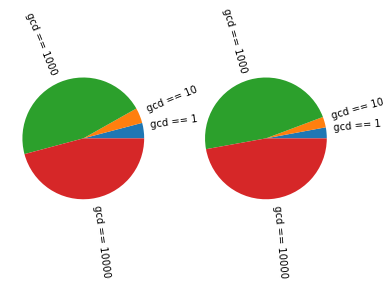

In [28]:
test_duplicated = [test_df_gcd_1.duplicated().sum(), test_df_gcd_10.duplicated().sum(), 
                   test_df_gcd_1000.duplicated().sum(), test_df_gcd_10000.duplicated().sum()]
train_duplicated = [train_df_gcd_1.duplicated().sum(), train_df_gcd_10.duplicated().sum(), 
                    train_df_gcd_1000.duplicated().sum(), train_df_gcd_10000.duplicated().sum()]
labels = ['gcd == 1', 'gcd == 10', 'gcd == 1000', 'gcd == 10000']

plt.subplot(1, 2, 1)
plt.pie(train_duplicated, labels = labels, rotatelabels = True);

plt.subplot(1, 2, 2)
plt.pie(test_duplicated, labels = labels, rotatelabels = True);

Отсюда следует, что чем меньше раз были прочитаны цепочки из десяти нуклеотидов, тем выше вероятность того, что мы получим совершенно идентичные строки, так что всё логично

Повторы в данных исказят результаты валидации, так что от них надо избавиться. Снова немного нудной работы

In [29]:
train_df_gcd_1.drop_duplicates(inplace = True)
train_df_gcd_10.drop_duplicates(inplace = True)
train_df_gcd_1000.drop_duplicates(inplace = True)
train_df_gcd_10000.drop_duplicates(inplace = True)

train_df_gcd_1.index = pd.RangeIndex(len(train_df_gcd_1))
train_df_gcd_10.index = pd.RangeIndex(len(train_df_gcd_10))
train_df_gcd_1000.index = pd.RangeIndex(len(train_df_gcd_1000))
train_df_gcd_10000.index = pd.RangeIndex(len(train_df_gcd_10000))

In [30]:
def plot_eigvals(F):
    '''
    Вычисляет собственные значения матрицы F_s.T * F_s, где F_s - стандартизовананя матрица F,
    сортирует их по убыванию и строит график, на котором по оси абсцисс отложены числа от 0 до 
    кол-во собственных значения - 1, а по оси ординат непосредственно собственные значения
    
    Возвращаемое значение:
        Массив собственных значений, отсортированный по убыванию   
    '''
    EPS = 1e-6
    cols = F.columns
    mean = F.mean()
    std = F.std() + EPS

    F = (F - mean) / std

    eigvals, _ = np.linalg.eig(F.T @ F)
    # Нас интересуют собственные значения, отсортированные по убыванию
    eigvals = np.sort(eigvals)[::-1]
    
    F = F * std + mean
    
    eigvals, _ = np.linalg.eig(F.T @ F)
    
    eigvals = pd.Series(eigvals)
    # Да, столь большие размеры пригодятся
    plt.figure(figsize = (14, 8))
    plt.xlabel('Номер (по убыванию) собственного значения')
    plt.ylabel('Соответствующее собственное значение')
    plt.grid()
    
    # Спойлер: большинство собственных значений будут малы относительно нескольких
    # больших, поэтому смотрим только на 25 первых, чтобы можно было разглядеть 
    # хоть что-то содержательное
    sns.lineplot(data = eigvals[:25])
    
    return eigvals

In [44]:
def plot_pca(X, n_comps):
    '''Применяет метод главных компонент с n_comps компонентами и строит pairplot для получившейся таблицы'''
    X_before_pca = X.copy()
    # Стандартизируем
    EPS = 1e-6
    cols = X.drop('target', axis = 1).columns
    mean = X[cols].mean()
    std = X[cols].std() + EPS
    X[cols] = (X[cols] - mean) / std
    
    pca = PCA(n_components = n_comps)
    X = pca.fit_transform(X.drop('target', axis = 1))
    X = pd.DataFrame(X, index = np.arange(len(X_before_pca)), 
                     columns = [f'PC{i}' for i in range(1, n_comps + 1)])
    X['target'] = target_le.inverse_transform(X_before_pca['target'])
    
    sns.pairplot(X, hue = 'target')
    # Выносим легенду за пределы графика
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=3)
    # Вертаем как было
    X = X_before_pca

Это пригодится попозже

In [32]:
test_columns = test_df_gcd_1.columns

Убираем лишние нули

In [33]:
train_df_gcd_10.loc[:, test_columns] = train_df_gcd_10[test_columns] // 10
train_df_gcd_1000.loc[:, test_columns] = train_df_gcd_1000[test_columns] // 1000
train_df_gcd_10000.loc[:, test_columns] = train_df_gcd_10000[test_columns] // 10000

In [34]:
test_df_gcd_10.loc[:, test_columns] = test_df_gcd_10[test_columns] // 10
test_df_gcd_1000.loc[:, test_columns] = test_df_gcd_1000[test_columns] // 1000
test_df_gcd_10000.loc[:, test_columns] = test_df_gcd_10000[test_columns] // 10000

Пандас любит поругаться ни на что, так что вот такая ячейка не помешает

In [35]:
import warnings
warnings.filterwarnings("ignore")

Осталось только предварительно заметить, что после удаления дупликатов все 4 тренировочных набор остались сбалансированными, а значит никаких ухищрений для валидации проводить не надо

In [36]:
train_df_gcd_1['target'].value_counts()

0    4753
5    4731
8    4727
6    4696
7    4692
1    4688
9    4670
4    4651
2    4649
3    4597
Name: target, dtype: int64

In [37]:
train_df_gcd_10['target'].value_counts()

0    4749
1    4738
9    4715
2    4712
6    4701
3    4696
7    4665
5    4663
8    4647
4    4622
Name: target, dtype: int64

In [38]:
train_df_gcd_1000['target'].value_counts()

7    1526
1    1525
8    1515
5    1513
0    1513
9    1513
3    1506
4    1505
2    1496
6    1485
Name: target, dtype: int64

In [39]:
train_df_gcd_10000['target'].value_counts()

7    1532
8    1527
1    1518
2    1516
5    1513
9    1508
6    1508
4    1507
0    1507
3    1498
Name: target, dtype: int64

# gcd == 1

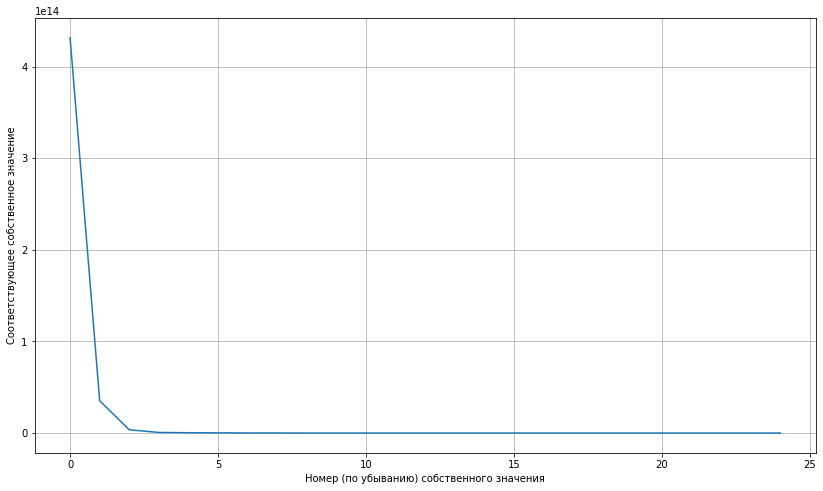

In [40]:
eig_1 = plot_eigvals(train_df_gcd_1)

С одной стороны, видим "резкий спуск", что сигнализирует о том, что метод главных компонент тут более чем уместен и нам должно хватать 4-6 главных компонент. Однако не секрет, что эффективность применения оного для сжатия пространства признаков в подпространство размерности m определяется близостью к единице отношения

$$\frac{\lambda_1 + \lambda_2 + ... + \lambda_m}{\lambda_1 + \lambda_2 + ... + \lambda_n}$$

где $\lambda_1, \lambda_2, ... , \lambda_n$ - упрорядоченные по убыванию собственные значения матрицы F.T * F 

Так что проверим умозрительное заключение подсчётами:

In [41]:
eig_1[:6].sum() / eig_1.sum()

0.9996956861017766

Ну и действительно. Метод главных компонент кажется более чем уместным: сохранив всего 6 главных компонент, мы почти не потеряем информации

No handles with labels found to put in legend.


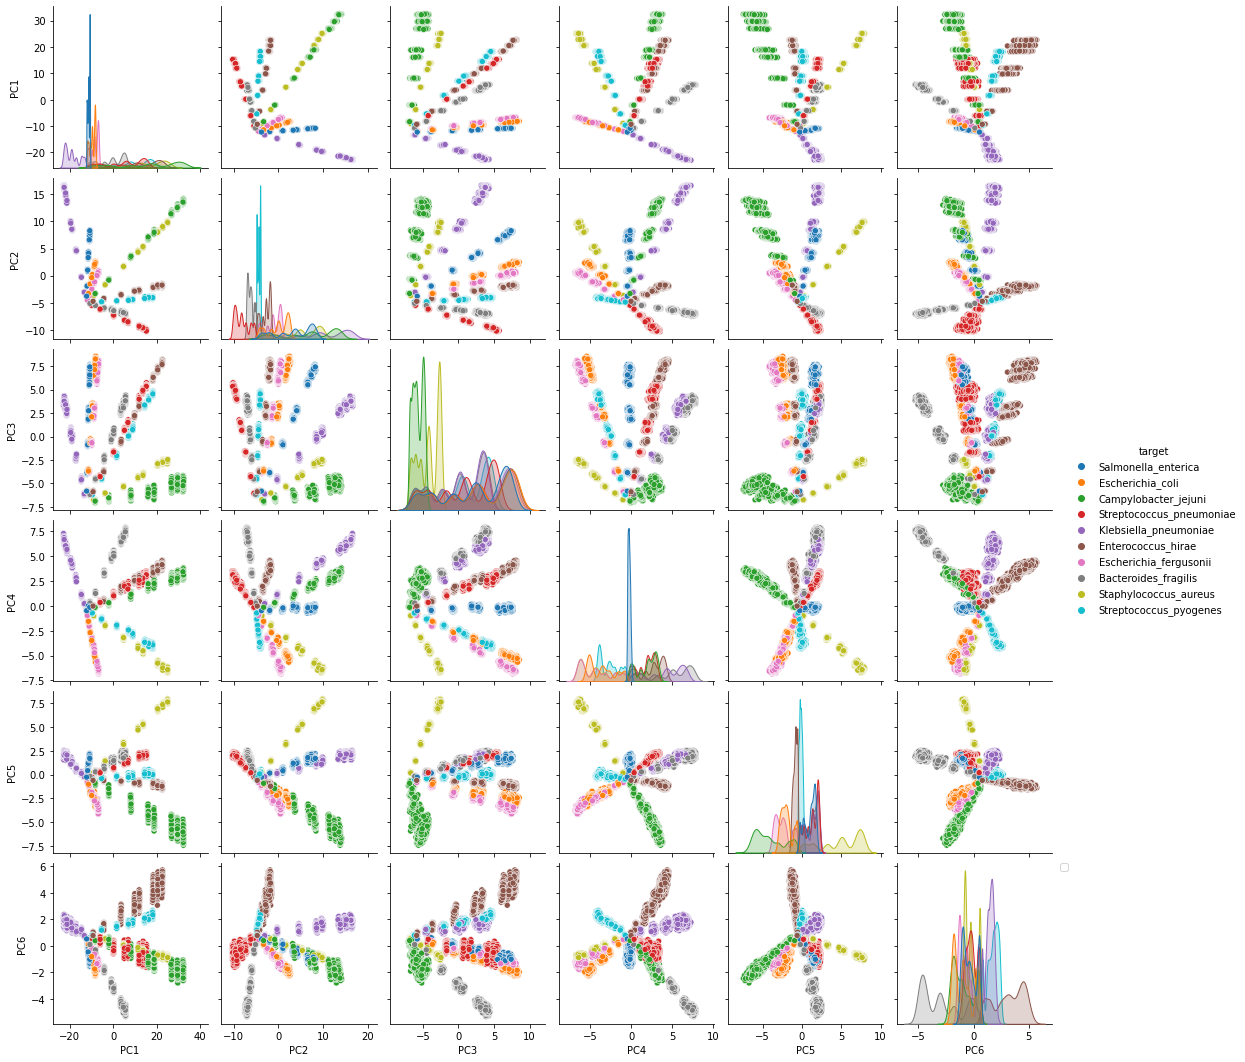

In [45]:
plot_pca(train_df_gcd_1, 6)

Глядя на 

1. Графики зависимости главных компонент друг от друга, 

2. Графики ядерных оценок плотностей распределения главных компонент, 

Хочется попробовать

1. SVM

2. Что-то, основанное на решающих деревьях 

In [77]:
from sklearn.svm import SVC

svc_param_grid_1 = {'kernel': ['rbf'],
                    'C': [15, 16, 17, 18, 19, 20],
                    'gamma': [0.3, 0.5, 0.75, 1]}

log_1 = Logger(estimator = 'SVC',
               val_info = '7 блоков, со стандартизацией, PCA и стандартизацией после PCA. Главных компонент 6', 
               grid = svc_param_grid_1, outfile = r'logs\logs_1.txt')

log_1.best_params, log_1.scores = kosherGridSearchCV(train_df_gcd_1.drop('target', axis = 1), train_df_gcd_1['target'],
                                                     svc_param_grid_1, test_columns, compare_means, 
                                                     42, 7, to_standard = True, with_pca = True, pca_standard = True,
                                                     n_comps = 6, model = SVC)

            
log_1.make_note()

  0%|          | 0/24 [00:00<?, ?it/s]

Точность: 0.9992957350243398 +- 0.001361482968945627 (mean +- std)
Худшая точность: 0.9959665371974903
Медианная точность: 0.9998505901688332
Лучшая точность: 1.0



Более чем

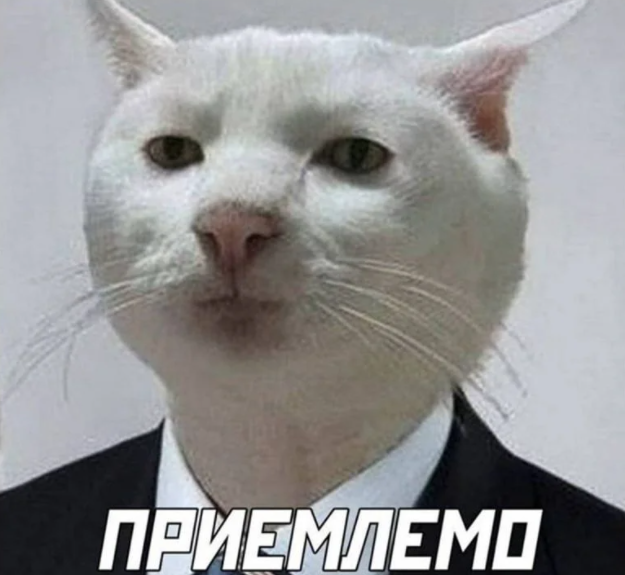

Касаемо второго пункта, если нам нужна стопроцентная точность и довольно высокая степень интерпретируемости, можем применить его величество XGBoost. Дабы убедить вас в стопроцентной точности, провалидуюсь по 50-ти блокам 

In [47]:
from xgboost import XGBClassifier

xgb_param_grid_1 = {'booster': ['dart'],
                    'verbosity': [0],
                    'max_depth': [6],
                    'eta': [0.03],
                    'n_estimators': [10],
                    'subsample': [0.25],
                    'colsample_bytree': [0.4],
                    'random_state': [42],
                    'use_label_encoder': [False]}

log_1 = Logger(val_info = '50 блоков, без стандартизации и PCA', 
               grid = xgb_param_grid_1, outfile = r'logs\logs_1.txt')

log_1.best_params, log_1.scores = kosherGridSearchCV(train_df_gcd_1.drop('target', axis = 1), train_df_gcd_1['target'],
                                                     xgb_param_grid_1, test_columns, compare_means, 
                                                     42, 50, to_standard = False, with_pca = False, pca_standard = False,
                                                     n_comps = -1, model = XGBClassifier)
            
log_1.make_note()

  0%|          | 0/1 [00:00<?, ?it/s]

Точность: 1.0 +- 0.0 (mean +- std)
Худшая точность: 1.0
Медианная точность: 1.0
Лучшая точность: 1.0



Примечательно, что почти стопроцентную точность можно получить с помощью всего одного дерева, что хорошо в случае, если нужна кристальная интерпетируемость

In [48]:
from sklearn.tree import DecisionTreeClassifier

dtc_param_grid = {'criterion': ['entropy'], 
                  'splitter': ['best'], 
                  'max_depth': [7, 8, 9],
                  'min_samples_split': [2, 3],
                  'min_samples_leaf': [2, 3],
                  'max_features': [0.25, 0.5, 1], 
                  'random_state': [42]}


log_1 = Logger(estimator = 'DecisionTreeClassifier', val_info = '10 блоков, без стандартизации, без PCA', 
               grid = dtc_param_grid, outfile = r'logs\logs_1.txt')

log_1.best_params, log_1.scores = kosherGridSearchCV(train_df_gcd_1.drop('target', axis = 1), train_df_gcd_1['target'],
                                                     dtc_param_grid, test_columns, compare_means, 
                                                     42, 10, to_standard = False, with_pca = False, pca_standard = False,
                                                     n_comps = -1, model = DecisionTreeClassifier)

            
log_1.make_note()

  0%|          | 0/36 [00:00<?, ?it/s]

Точность: 0.999573137541331 +- 0.00023381550800807897 (mean +- std)
Худшая точность: 0.9991462113127001
Медианная точность: 0.9996798747922352
Лучшая точность: 0.9997865983781477



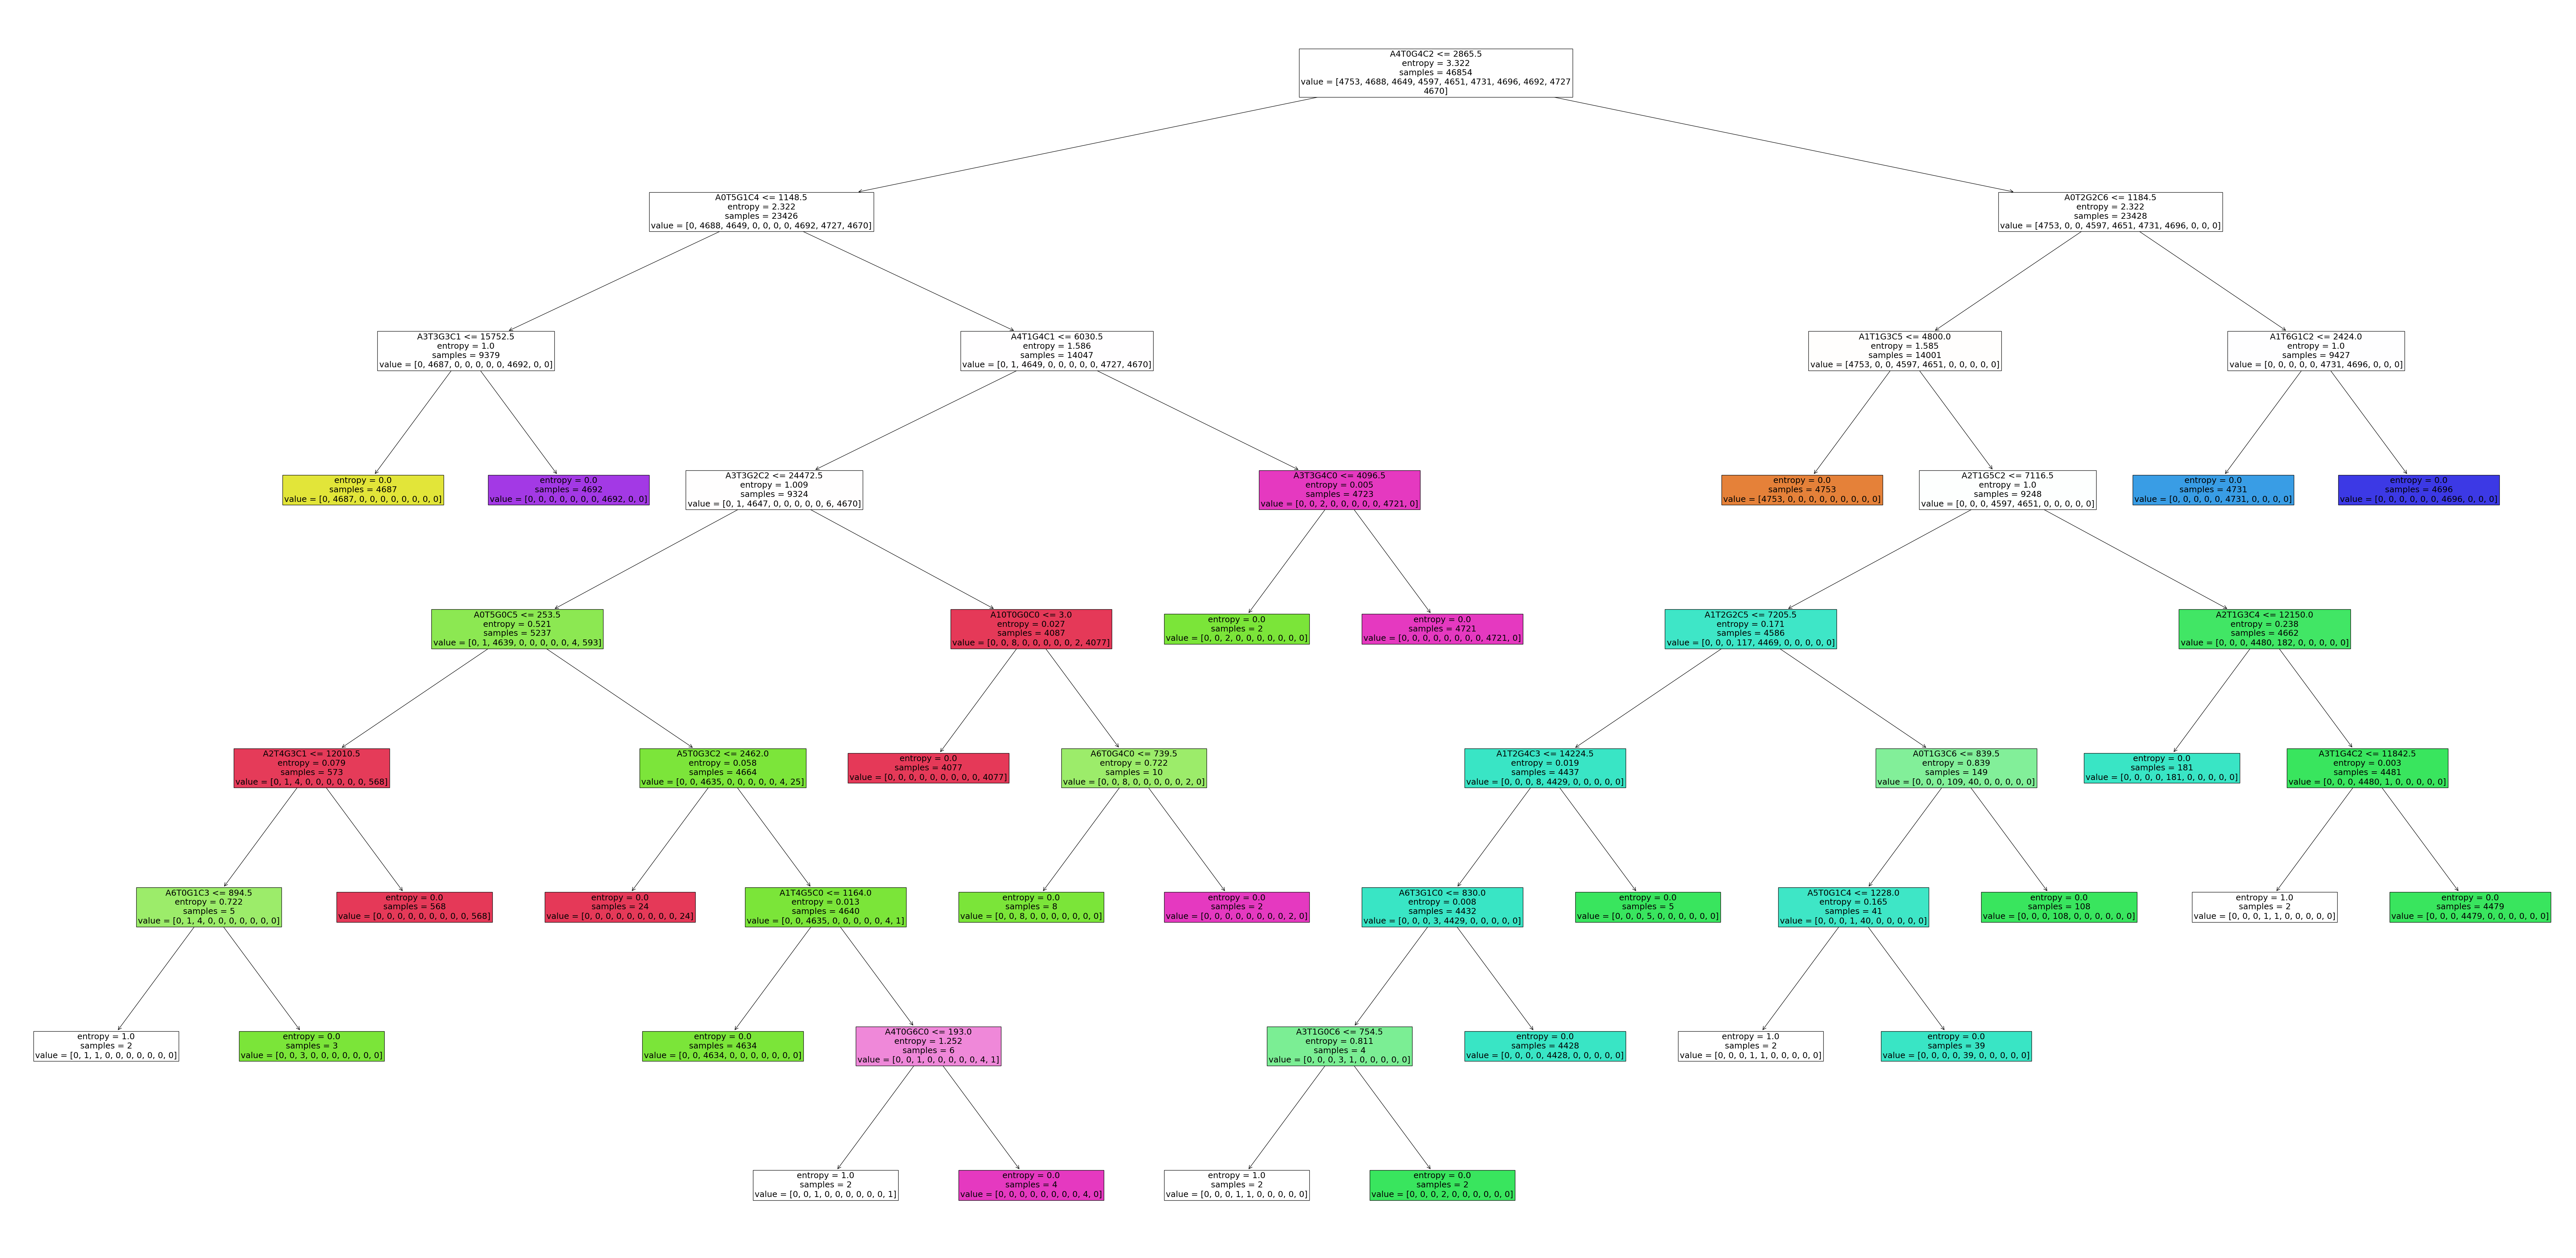

In [49]:
from sklearn import tree

m_1 = DecisionTreeClassifier(**log_1.best_params)
m_1.fit(train_df_gcd_1.drop('target', axis = 1), train_df_gcd_1['target']);

fig, ax = plt.subplots(figsize = (100, 50), dpi = 100)
tree.plot_tree(m_1, filled = True, feature_names = test_columns, 
               fontsize = 18, ax = ax)

fig.savefig(r'figs\tree_with_gcd_1.png')
fig.savefig(r'figs\tree_with_gcd_1.svg')

# gcd == 10

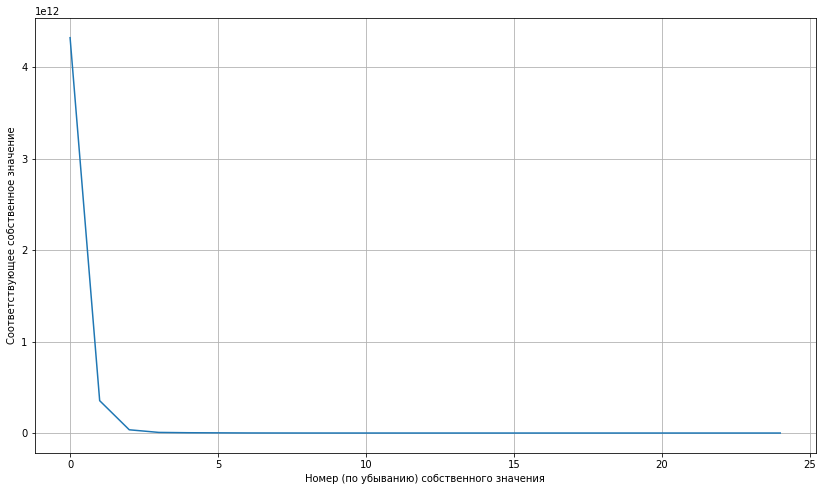

In [51]:
eig_10 = plot_eigvals(train_df_gcd_10)

Картина +- аналогичная. 

In [52]:
eig_10[:6].sum() / eig_10.sum() 

0.9990813963670022

No handles with labels found to put in legend.


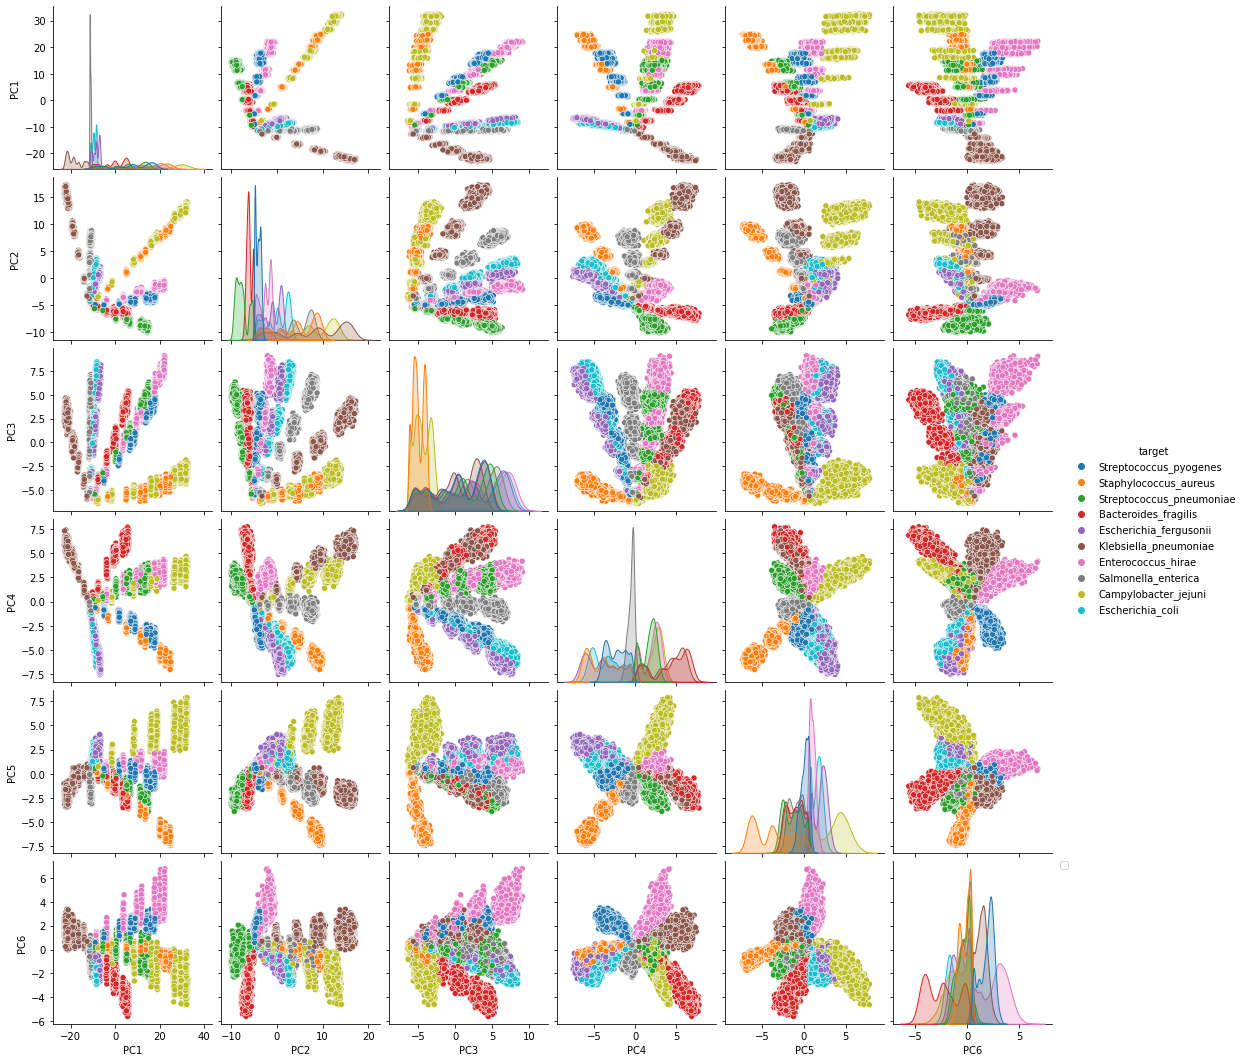

In [46]:
plot_pca(train_df_gcd_10, 6)

~~Кажется, что SVM'у будет достаточно тяжело, но какое-то результаты он всё же должен дать~

SVM уже не катит. Смотрите log_10.txt

Деревья всё ещё должны работать.

In [377]:
xgb_param_grid_10 = {'booster': ['dart'],
                    'verbosity': [0],
                    'max_depth': [8],
                    'eta': [0.25],
                    'n_estimators': [20],
                    'subsample': [0.15],
                    'colsample_bytree': [0.15],
                    'random_state': [42],
                    'use_label_encoder': [False]}

log_10 = Logger(val_info = '10 блоков, без стандартизации и PCA', 
                grid = xgb_param_grid_10, outfile = r'logs\logs_10.txt')

log_10.best_params, log_10.scores = kosherGridSearchCV(train_df_gcd_10.drop('target', axis = 1), train_df_gcd_10['target'],
                                                       xgb_param_grid_10, test_columns, compare_means, 
                                                       42, 10, to_standard = False, with_pca = False, pca_standard = False,
                                                       n_comps = -1, model = XGBClassifier)

log_10.make_note()

  0%|          | 0/1 [00:00<?, ?it/s]

Точность: 0.9987208868408816 +- 0.0006104744268313172 (mean +- std)
Худшая точность: 0.9974419100405031
Медианная точность: 0.998934129183543
Лучшая точность: 0.9995736516734172



Одно дерево всё ещё даёт более чем неплохую точность:

In [374]:
dtc_param_grid_10 = {'criterion': ['entropy'], 
                      'splitter': ['best'], 
                      'max_depth': [7, 8, 9, 10],
                      'min_samples_split': [2, 3, 4],
                      'min_samples_leaf': [2, 3, 4],
                      'min_weight_fraction_leaf': [0.0, 0.25],
                      'max_features': [1], 
                      'random_state': [42]}

log_10 = Logger(estimator = 'DecisionTreeClassifier', val_info = '10 блоков, без стандартизации и PCA', 
                grid = dtc_param_grid_10, outfile = r'logs\logs_10.txt')

log_10.best_params, log_10.scores = kosherGridSearchCV(train_df_gcd_10.drop('target', axis = 1), train_df_gcd_10['target'],
                                                       dtc_param_grid, test_columns, compare_means, 
                                                       42, 10, to_standard = False, with_pca = False, pca_standard = False,
                                                       n_comps = -1, model = DecisionTreeClassifier)

            
log_10.make_note()

  0%|          | 0/54 [00:00<?, ?it/s]

Точность: 0.9626503684640413 +- 0.0037159033982428927 (mean +- std)
Худшая точность: 0.9584310381581752
Медианная точность: 0.9623707603226975
Лучшая точность: 0.9695160946493285



# gcd == 1000

Вот тут начинаются проблемы. Примерно с этого момента точности измерений начинает не хватать и точность, близкую к 1 так просто получить уже не выйдет. Правда, нет худа без добра. Строк теперь не ~50k, а ~15k, что позволит быстрее перебирать модели и гиперпараметры, что вселяет надежду

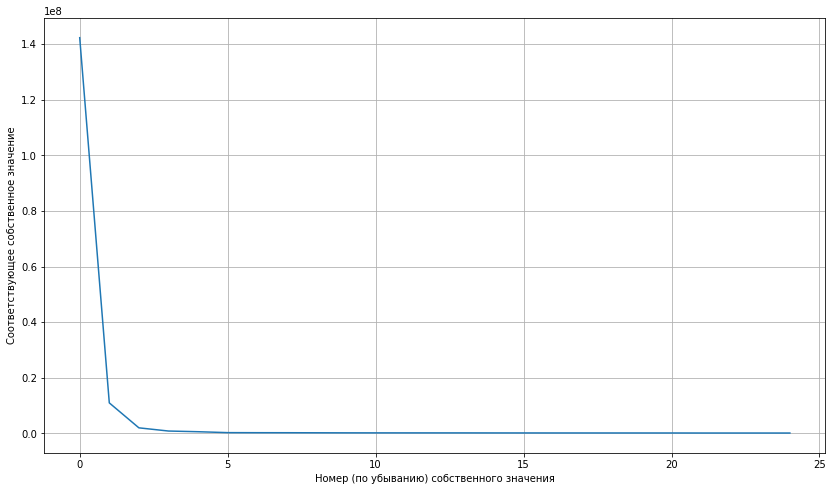

In [59]:
eig_1000 = plot_eigvals(train_df_gcd_1000)

Использовать PCA отныне не шибко разумно и делать этого я и не собираюсь. График построил на автомате.

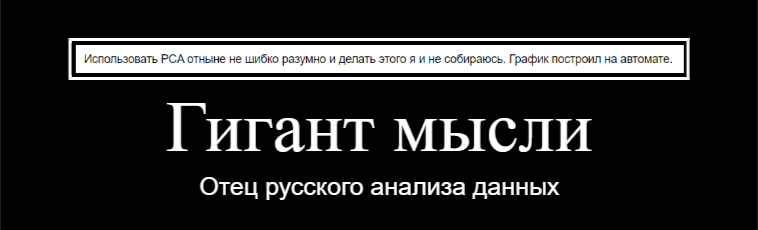

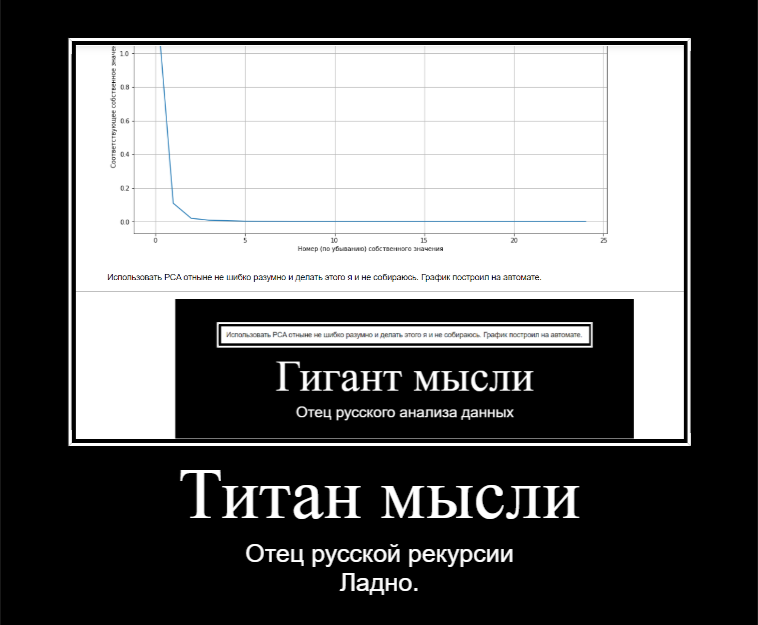

Ну-с, начнём по традции с XGB. Это будет baseline'ом на этой подзадаче 

In [409]:
xgb_param_grid_1000 = {'booster': ['gbtree', 'dart'],
                    'verbosity': [0],
                    'max_depth': [8, 9],
                    'eta': [0.01],
                    'n_estimators': [30, 50],
                    'subsample': [0.3, 0.4],
                    'colsample_bytree': [0.3, 0.4],
                    'random_state': [42],
                    'use_label_encoder': [False]}

log_1000 = Logger(val_info = '10 блоков, со стандартизацией и PCA', 
                  grid = xgb_param_grid_1000, outfile = r'logs\logs_1000.txt')

log_1000.best_params, log_1000.scores = kosherGridSearchCV(train_df_gcd_1000.drop('target', axis = 1), train_df_gcd_1000['target'],
                                                           xgb_param_grid_1000, test_columns, compare_means, 
                                                           42, 10, to_standard = False, with_pca = False, pca_standard = False,
                                                           n_comps = -1, model = XGBClassifier)

log_1000.make_note()

  0%|          | 0/32 [00:00<?, ?it/s]

Точность: 0.8629537564897591 +- 0.0073559522563706225 (mean +- std)
Худшая точность: 0.8496688741721854
Медианная точность: 0.8645249913323589
Лучшая точность: 0.8754966887417218



Примечательно (и прискорбно), что выборочная дисперсия заметно так подросла

Напомню, авторы статьи утверждали, что вычитание смещение позволяет сделать разницу между бактериями более явной. Ничего подобного не наблюдается. Ячейку с проверкой этого утверждения не привожу, но привожу выдержу из log_1000.txt:

```
Модель:
	XGBClassifier
Особенности предобработки данных:
	Каждая строка предварительно отнормирована, из каждой строки вычтено смещение
Особенности валидации:
	10 блоков, со стандартизацией и PCA
Сетка:
	booster: ['dart']
	verbosity: [0]
	max_depth: [9, 10]
	eta: [0.01]
	n_estimators: [50]
	subsample: [0.4]
	colsample_bytree: [0.3, 0.4]
	random_state: [42]
	use_label_encoder: [False]
Лучший набор параметров:
	booster: dart
	verbosity: 0
	max_depth: 10
	eta: 0.01
	n_estimators: 50
	subsample: 0.4
	colsample_bytree: 0.3
	random_state: 42
	use_label_encoder: False
Информация о методе сравнения моделей:
	Сравнивались средние значения
Информация о метрике:
	Точность: 0.869312908421436 +- 0.007468454373965464 (mean +- std)
	Худшая точность: 0.8556291390728477
	Медианная точность: 0.8701558858767922
```

Как видим, улучшение хоть и есть, но незначительное

Обратим внимание на то, что в данном подмассиве кол-во уникальных значений для каждого столбца невелико:

In [79]:
nuniques_1000 = []
for col in test_columns:
    nuniques_1000.append(train_df_gcd_1000[col].nunique())
max(nuniques_1000)

43

Это наводит на мысль о том, что все признаки имеет смысл рассматриват как категориальные, а значит имеет смысл попробовать CatBoost 

Предварительно проверим, нет ли константных признаков:

In [80]:
min(nuniques_1000)

2

К сожалению, catboost не хранит информацию о точности на отдельных блоках в процессе валидации, потому в логи будут сохраняться та информация, которую даёт CatBoost, а именно, среднее значение точности и стандартное отклонение

In [69]:
from catboost import Pool, CatBoostClassifier

cat_features = np.array(test_columns)

pool_1000 = Pool(train_df_gcd_1000.drop('target', axis = 1),
                 label = train_df_gcd_1000['target'],
                 cat_features = cat_features)

cat_param_grid_1000 = {'iterations': [4000],
                       'learning_rate': [0.03, 0.1, 0.3, 0.5],
                       'custom_loss': ['Accuracy'],
                       'logging_level': ['Silent'],
                       'task_type': ['GPU'], # На процессоре ужасающе медленно
                       'depth': [4, 5, 6, 7],
                       'random_seed': [42]}

m_1000 = CatBoostClassifier()
cv_1000 = m_1000.grid_search(param_grid = cat_param_grid_1000,
                             X = pool_1000,
                             cv = 5,
                             shuffle = True,
                             partition_random_seed = 42, 
                             stratified = True,
                             verbose = 4,
                             plot = True)

catboost_log_1000 = Logger(estimator = 'CatBoostClassifier',
                           val_info = '5 блоков, без стандартизации и PCA',
                           grid = cat_param_grid_1000, 
                           outfile = r'logs\logs_1000.txt')


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.3626721	best: 0.3626721 (0)	total: 1m 9s	remaining: 17m 22s
4:	loss: 0.3351950	best: 0.2710687 (1)	total: 6m 6s	remaining: 13m 27s
8:	loss: 0.3119788	best: 0.2660099 (5)	total: 12m 27s	remaining: 9m 41s
12:	loss: 0.3066007	best: 0.2660099 (5)	total: 21m 10s	remaining: 4m 53s
15:	loss: 0.3191105	best: 0.2660099 (5)	total: 28m 41s	remaining: 0us
Estimating final quality...


In [70]:
catboost_log_1000.scores = (cv_1000['cv_results']['test-Accuracy-mean'][-1], 
                            cv_1000['cv_results']['test-Accuracy-std'][-1])

catboost_log_1000.best_params = cv_1000['params']
catboost_log_1000.make_note()

Точность: 0.9028292022562082 +- 0.005447880509872442 (mean +- std)



Заметно лучше baseline'а, так что CatBoost оправдал возложенные на него надежды

# gcd == 10000

Действуем аналогично

In [27]:
from xgboost import XGBClassifier

xgb_param_grid_10000 = {'booster': ['dart'],
                        'verbosity': [0],
                        'max_depth': [6, 7],
                        'eta': [0.01],
                        'n_estimators': [50],
                        'subsample': [0.3],
                        'colsample_bytree': [0.3],
                        'random_state': [42],
                        'use_label_encoder': [False]}

log_10000 = Logger(val_info = '10 блоков, со стандартизацией и PCA', 
                   grid = xgb_param_grid_10000, outfile = r'logs\logs_10000.txt')

log_10000.best_params, log_10000.scores = kosherGridSearchCV(train_df_gcd_10000.drop('target', axis = 1), train_df_gcd_10000['target'],
                                                           xgb_param_grid_10000, test_columns, compare_means, 
                                                           42, 10, to_standard = False, with_pca = False, pca_standard = False,
                                                           n_comps = -1, model = XGBClassifier)

log_10000.make_note()

  0%|          | 0/2 [00:00<?, ?it/s]

Точность: 0.7264430418539107 +- 0.008999255268172386 (mean +- std)
Худшая точность: 0.712491738268341
Медианная точность: 0.7264624683827785
Лучшая точность: 0.739101717305152



In [85]:
pool_10000 = Pool(train_df_gcd_10000.drop('target', axis = 1),
                  label = train_df_gcd_10000['target'],
                  cat_features = cat_features)

cat_param_grid_10000 = {'iterations': [3500],
                        'learning_rate': [0.1, 0.05],
                        'custom_loss': ['Accuracy'],
                        'logging_level': ['Silent'],
                        'task_type': ['GPU'],
                        'depth': [6, 7, 8],
                        'random_seed': [42]}

m_10000 = CatBoostClassifier()
gs_10000 = m_10000.grid_search(param_grid = cat_param_grid_10000,
                               X = pool_10000,
                               cv = 5,
                               shuffle = True,
                               partition_random_seed = 42, 
                               stratified = True,
                               verbose = 4,
                               plot = True)

catboost_log_10000 = Logger(estimator = 'CatBoostClassifier',
                            val_info = '5 блоков, без стандартизации и PCA',
                            grid = cat_param_grid_10000, 
                            outfile = r'logs\logs_10000.txt')

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.5388053	best: 0.5388053 (0)	total: 1m 28s	remaining: 7m 24s
4:	loss: 0.5194077	best: 0.5167209 (2)	total: 9m 59s	remaining: 1m 59s
5:	loss: 0.5518669	best: 0.5167209 (2)	total: 13m 1s	remaining: 0us
Estimating final quality...


In [89]:
catboost_log_10000.scores = (gs_10000['cv_results']['test-Accuracy-mean'][-1], 
                             gs_10000['cv_results']['test-Accuracy-std'][-1])

catboost_log_10000.best_params = gs_10000['params']
catboost_log_10000.make_note()

Точность: 0.8174973487189032 +- 0.007774003389956868 (mean +- std)



# Предсказания на тестовом наборе

In [210]:
test_df_len = len(test_df_gcd_1) + len(test_df_gcd_10) + len(test_df_gcd_1000) + len(test_df_gcd_10000)
preds = pd.Series([-1] * test_df_len, dtype = 'object')

In [211]:
xgb_best_params_1 = {'booster': 'dart',
                     'verbosity': 0,
                     'max_depth': 6,
                     'eta': 0.03,
                     'n_estimators': 10,
                     'subsample': 0.25,
                     'colsample_bytree': 0.4,
                     'random_state': 42,
                     'use_label_encoder': False}
m_1 = XGBClassifier(**xgb_best_params_1)
m_1.fit(train_df_gcd_1.drop('target', axis = 1), train_df_gcd_1['target'])
preds[test_gcds == 1] = target_le.inverse_transform(m_1.predict(test_df_gcd_1))

In [212]:
xgb_best_params_10 = {'booster': 'dart',
                      'verbosity': 0,
                      'max_depth': 8,
                      'eta': 0.25,
                      'n_estimators': 20,
                      'subsample': 0.15,
                      'colsample_bytree': 0.15,
                      'random_state': 42,
                      'use_label_encoder': False}
m_10 = XGBClassifier(**xgb_best_params_10)
m_10.fit(train_df_gcd_10.drop('target', axis = 1), train_df_gcd_10['target'])
preds[test_gcds == 10] = target_le.inverse_transform(m_10.predict(test_df_gcd_10))

In [213]:
preds[test_gcds == 1000] = target_le.inverse_transform(m_1000.predict(test_df_gcd_1000))
preds[test_gcds == 10000] = target_le.inverse_transform(m_10000.predict(test_df_gcd_10000))

In [216]:
write_in_file(preds, 'predictions\preds.csv')

Итоговая точность: 0.91243